In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [45]:
df = pd.read_csv("laptop_price.csv", encoding="latin-1")
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [46]:
df = df.drop("Product", axis=1)

In [47]:
df = df.join(pd.get_dummies(df.Company))
df = df.drop("Company", axis=1)

df = df.join(pd.get_dummies(df.TypeName))
df = df.drop("TypeName", axis=1)

In [48]:
df["ScreenResolution"] = df.ScreenResolution.str.split(" ").apply(lambda x: x[-1])
df["Screen Width"] = df.ScreenResolution.str.split("x").apply(lambda x: x[0])
df["Screen Height"] = df.ScreenResolution.str.split("x").apply(lambda x: x[1])

df = df.drop("ScreenResolution", axis=1)

df["Screen Width"] = df["Screen Width"].astype(int)
df["Screen Height"] = df["Screen Height"].astype(int)


In [49]:
df["CPU Brand"] = df.Cpu.str.split(" ").apply(lambda x: x[0])
df["CPU Frequency"] = df.Cpu.str.split(" ").apply(lambda x: x[-1])

df = df.drop("Cpu", axis=1)

df["CPU Frequency"] = df["CPU Frequency"].str[:-3].astype(float)

In [50]:
df["Ram"] = df["Ram"].str[:-2].astype(int)

In [51]:
df["Memory Amount"] = df.Memory.str.split(" ").apply(lambda x: x[0])
df["Memory Type"] = df.Memory.str.split(" ").apply(lambda x: x[1])

def memory_to_mb(value):
    if "GB" in value:
        return float(value.replace("GB", "")) * 1000
    elif "TB" in value:
        return float(value.replace("TB", "")) * 1_000_000

df["Memory Amount"] = df["Memory Amount"].apply(memory_to_mb)
df = df.drop("Memory", axis=1)

df = df.join(pd.get_dummies(df["Memory Type"], prefix="Memory"))
df = df.drop("Memory Type", axis=1)

In [52]:
df["Weight"] = df["Weight"].str[:-2].astype(float)

In [53]:
df["GPU Brand"] = df.Gpu.str.split(" ").apply(lambda x: x[0])
df = df.drop("Gpu", axis=1)

In [54]:
df = df.join(pd.get_dummies(df.OpSys))
df = df.drop("OpSys", axis=1)

In [55]:
cpu_dummies = pd.get_dummies(df["CPU Brand"], prefix="CPU")
df = df.join(cpu_dummies)
df = df.drop("CPU Brand", axis=1)

gpu_dummies = pd.get_dummies(df["GPU Brand"], prefix="GPU")
df = df.join(gpu_dummies)
df = df.drop("GPU Brand", axis=1)

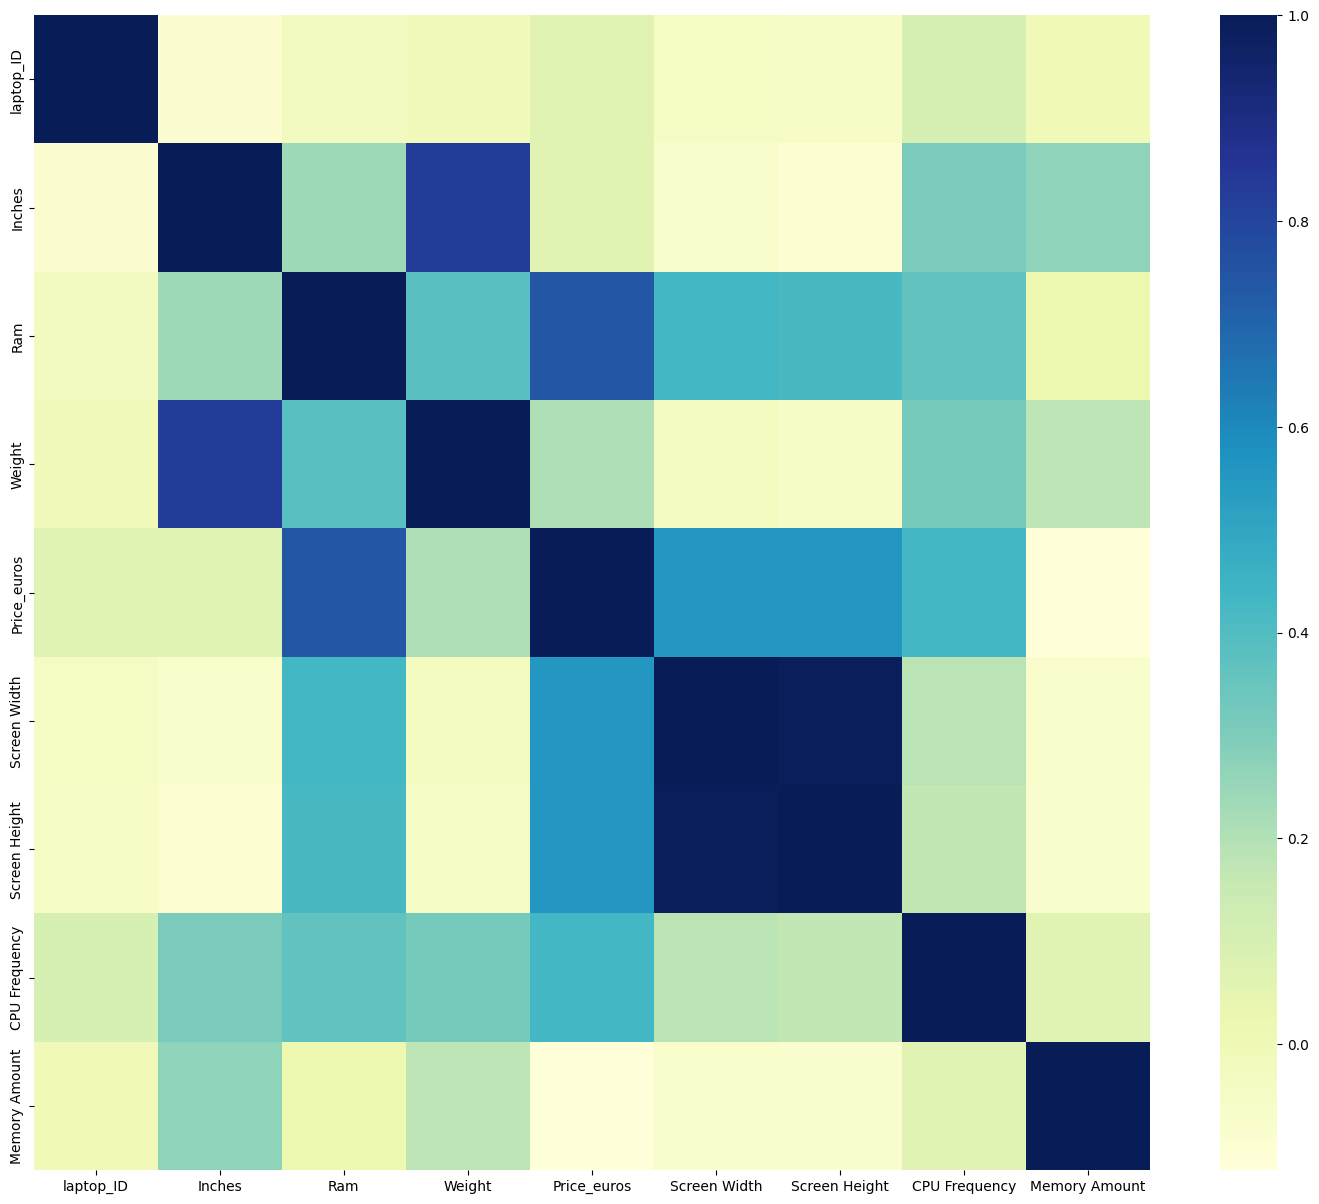

In [56]:
plt.figure(figsize=(18, 15))
sns.heatmap(
    df.select_dtypes(include="number").corr(),
    cmap="YlGnBu"
)
plt.show()

In [57]:
target_correlations = (
    df.select_dtypes(include="number")
      .corr()["Price_euros"]
      .abs()
      .sort_values()
)

selected_features = target_correlations.tail(21).index.tolist()
limited_df = df[selected_features]
limited_df.head()

,laptop_ID,Inches,Memory Amount,Weight,CPU Frequency,Screen Height,Screen Width,Ram,Price_euros
0,1,13.3,128000.0,1.37,2.3,1600,2560,8,1339.69
1,2,13.3,128000.0,1.34,1.8,900,1440,8,898.94
2,3,15.6,256000.0,1.86,2.5,1080,1920,8,575.00
3,4,15.4,512000.0,1.83,2.7,1800,2880,16,2537.45
4,5,13.3,256000.0,1.37,3.1,1600,2560,8,1803.60


In [58]:
X = limited_df.drop("Price_euros", axis=1)
y = limited_df["Price_euros"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

In [59]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train_scaled, y_train)

forest.score(X_test_scaled, y_test)

0.8007374256821531

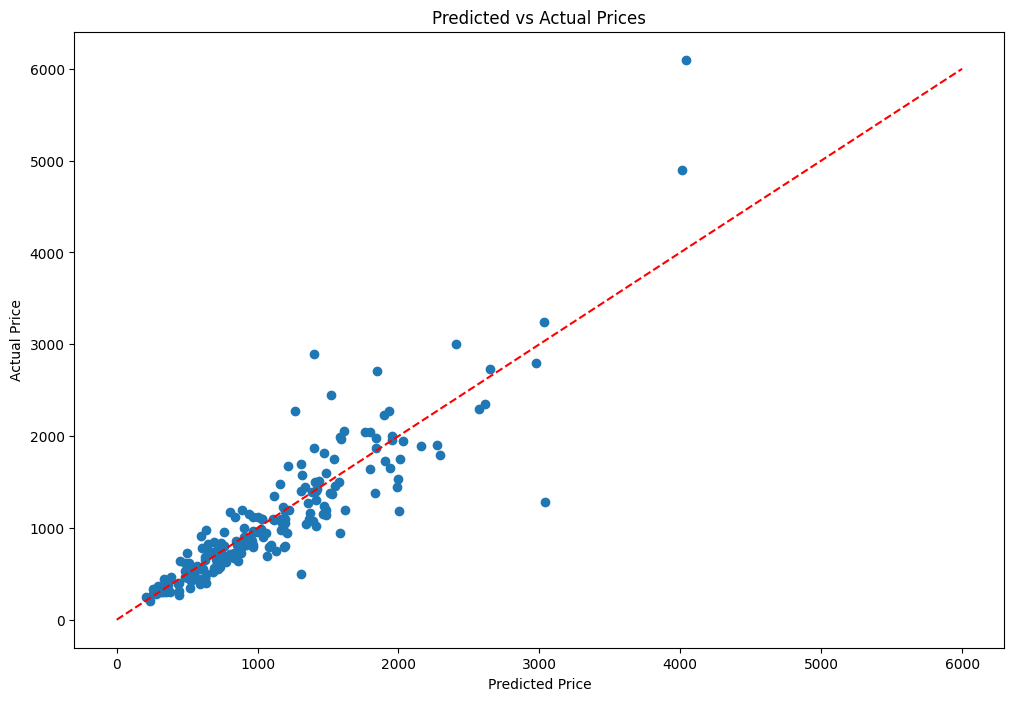

In [61]:
y_pred = forest.predict(X_test_scaled)

plt.figure(figsize=(12, 8))
plt.scatter(y_pred, y_test)
plt.plot([0, 6000], [0, 6000], "r--")
plt.xlabel("Predicted Price")
plt.ylabel("Actual Price")
plt.title("Predicted vs Actual Prices")
plt.show()

In [62]:
X_new_scaled = scaler.transform([X_test.iloc[0]])
forest.predict(X_new_scaled), y_test.iloc[0]

/var/data/python/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


(array([1213.056]), np.float64(1672.0))